In [1]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

## Helpful functions

In [2]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [3]:
FIGSIZE = (18,8)

# Reading in data

In [4]:
df = pd.read_csv('train.csv')
df.columns = df.columns.str.replace(' ', '_').str.lower()

df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d')

In [5]:
min(df['date']), max(df['date'])

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [6]:
df.head(10)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0
5,5,2013-01-01,1,BREAD/BAKERY,0.00,0
6,6,2013-01-01,1,CELEBRATION,0.00,0
7,7,2013-01-01,1,CLEANING,0.00,0
8,8,2013-01-01,1,DAIRY,0.00,0
9,9,2013-01-01,1,DELI,0.00,0


In [7]:
df.shape

(3000888, 6)

In [8]:
agg_df = df.groupby(['date', 'family']).agg({'sales':'sum'}).reset_index().sort_values(['family', 'date'])

In [9]:
agg_df.head()

,date,family,sales
0,2013-01-01,AUTOMOTIVE,0.00
33,2013-01-02,AUTOMOTIVE,255.00
66,2013-01-03,AUTOMOTIVE,161.00
99,2013-01-04,AUTOMOTIVE,169.00
132,2013-01-05,AUTOMOTIVE,342.00


In [10]:
agg_df.shape

(55572, 3)

In [11]:
total_sales_df = agg_df.pivot(index='date', columns='family', values='sales')
total_sales_df.head(10)

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,EGGS,FROZEN FOODS,GROCERY I,GROCERY II,HARDWARE,HOME AND KITCHEN I,HOME AND KITCHEN II,HOME APPLIANCES,HOME CARE,LADIESWEAR,LAWN AND GARDEN,LINGERIE,"LIQUOR,WINE,BEER",MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.00,0.00,2.00,810.00,0.00,180.59,0.00,186.00,143.00,71.09,46.00,29.65,700.00,15.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,5.00,105.00,0.00,110.80,25.00,0.00,0.00,42.64,37.85,0.00,0.00,0.00
2013-01-02,255.00,0.00,207.00,72092.00,0.00,26246.32,0.00,74629.00,23381.00,15754.50,10932.00,7115.39,202020.00,1476.00,46.00,0.00,0.00,21.00,0.00,0.00,121.00,469.00,2411.00,0.00,20871.46,17204.00,0.00,0.00,13975.88,5338.11,0.00,0.00,1526.75
2013-01-03,161.00,0.00,125.00,52105.00,0.00,18456.48,0.00,55893.00,18001.00,11172.45,7358.00,4760.81,144878.00,1048.00,37.00,0.00,0.00,15.00,0.00,0.00,83.00,366.00,2476.00,0.00,16597.40,12568.00,0.00,0.00,10674.39,3591.39,0.00,0.00,1094.31
2013-01-04,169.00,0.00,133.00,54167.00,0.00,16721.97,0.00,52064.00,18148.00,10143.21,6760.00,4525.93,135754.00,1031.00,57.00,0.00,0.00,13.00,0.00,0.00,127.00,382.00,4796.00,0.00,21625.96,11303.00,0.00,0.00,10772.52,4472.97,0.00,0.00,1293.12
2013-01-05,342.00,0.00,191.00,77818.00,0.00,22367.76,0.00,70128.00,23082.00,13734.95,8576.00,5781.61,188356.00,1273.00,87.00,0.00,0.00,11.00,0.00,0.00,180.00,458.00,6715.00,0.00,20879.09,16819.00,0.00,0.00,13475.01,5830.07,0.00,0.00,1245.64
2013-01-06,360.00,0.00,265.00,86184.00,0.00,26861.67,0.00,74295.00,23660.00,16229.26,10933.00,6114.88,207297.00,1306.00,87.00,0.00,0.00,17.00,0.00,0.00,161.00,781.00,0.00,0.00,21880.01,19665.00,0.00,0.00,15921.10,6233.71,0.00,0.00,1443.78
2013-01-07,189.00,0.00,124.00,51619.00,0.00,17646.15,0.00,50036.00,15839.00,9647.74,6486.00,3823.62,133189.00,846.00,55.00,0.00,0.00,12.00,0.00,0.00,73.00,480.00,1865.00,0.00,18314.18,11205.00,0.00,0.00,10086.56,3638.76,0.00,0.00,947.80
2013-01-08,229.00,0.00,116.00,46941.00,0.00,15805.76,0.00,45075.00,14532.00,8269.92,5575.00,3484.75,133290.00,746.00,57.00,0.00,0.00,9.00,0.00,0.00,96.00,484.00,2009.00,0.00,16200.32,12109.00,0.00,0.00,8724.14,3555.97,0.00,0.00,1038.92
2013-01-09,164.00,0.00,104.00,47910.00,0.00,16002.83,0.00,42958.00,16250.00,7817.09,5839.00,3689.60,115871.00,844.00,38.00,0.00,0.00,11.00,0.00,0.00,129.00,547.00,2256.00,0.00,19139.78,9489.00,0.00,0.00,8488.30,3994.90,0.00,0.00,988.31


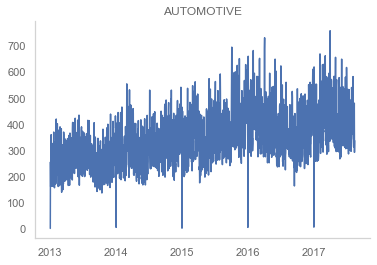

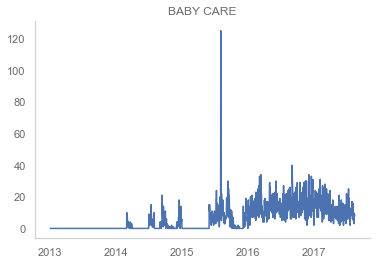

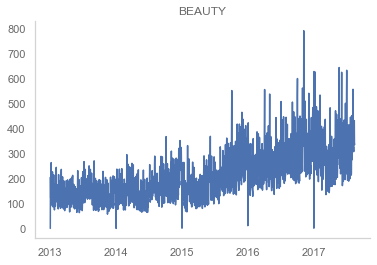

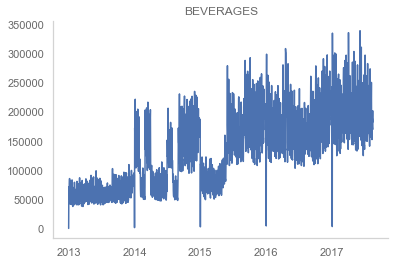

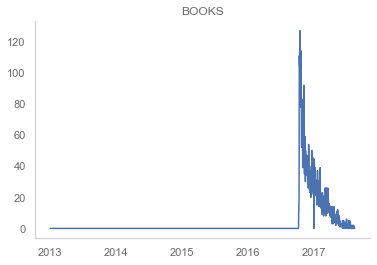

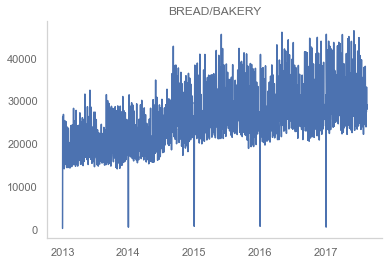

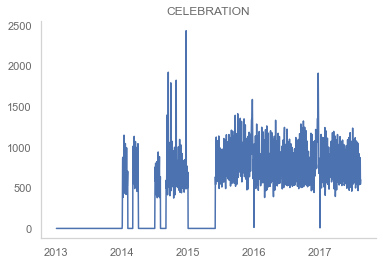

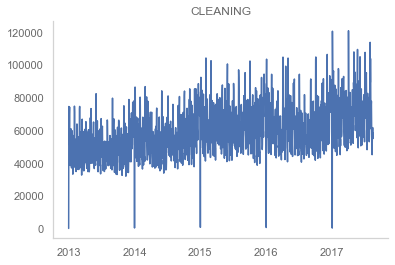

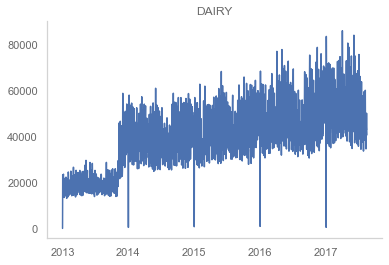

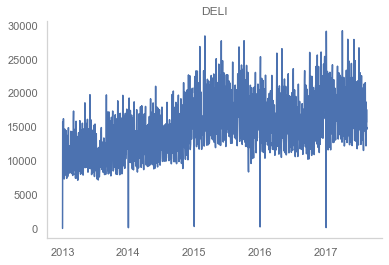

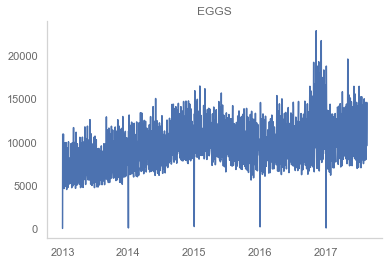

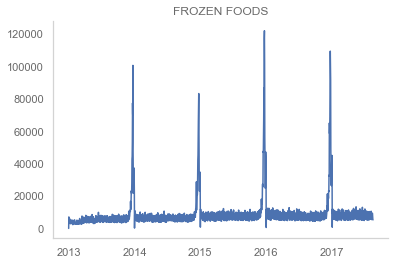

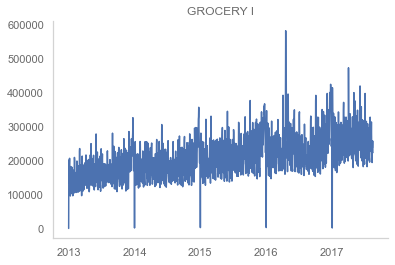

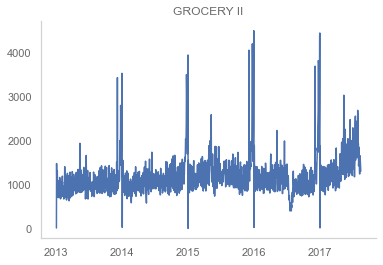

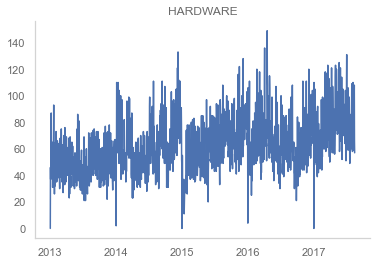

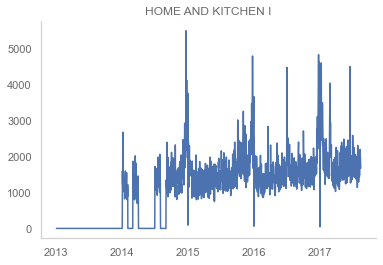

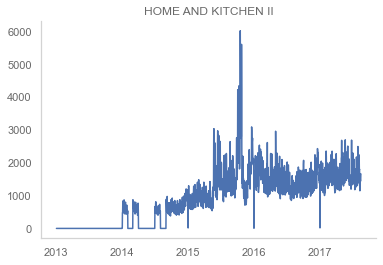

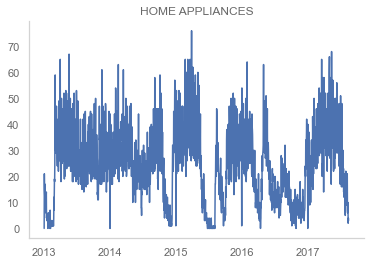

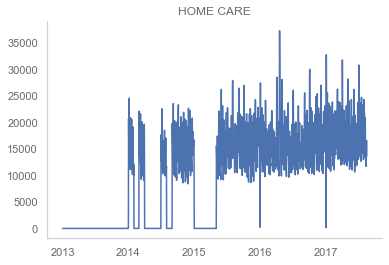

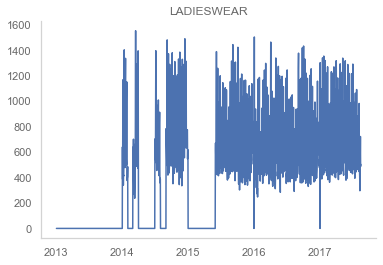

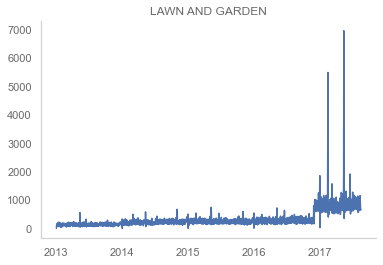

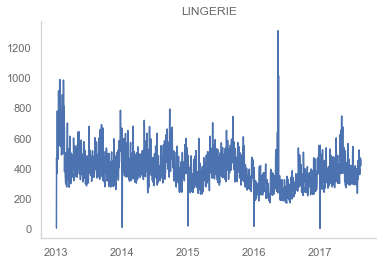

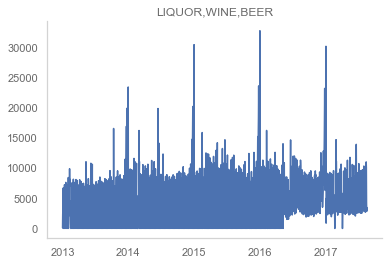

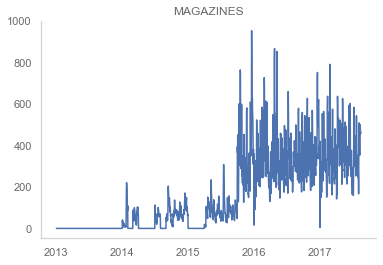

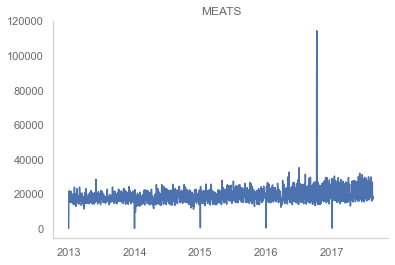

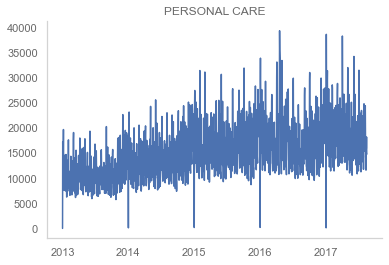

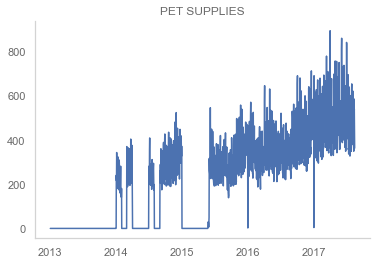

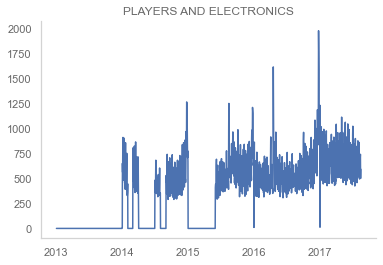

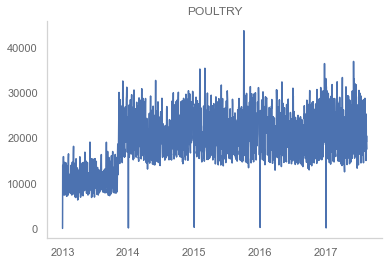

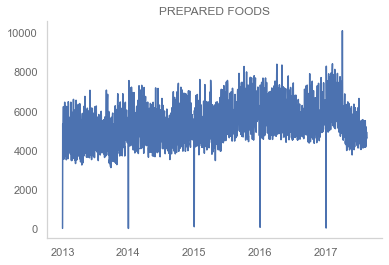

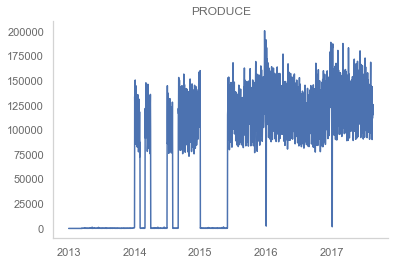

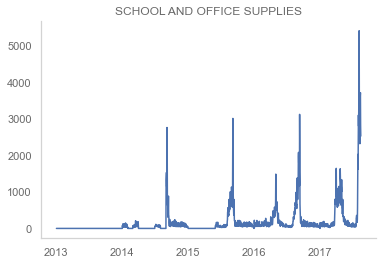

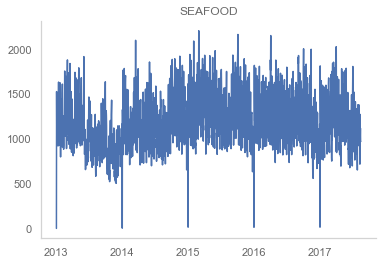

In [12]:
for column in total_sales_df.columns:
    plt.plot(total_sales_df[column])
    plt.title(column)
    plt.show()

In [13]:
total_sales_df = total_sales_df[total_sales_df.index >= '2015-08-15']

In [14]:
missing_data(total_sales_df)

,Total,Percent,Types
family,,,
AUTOMOTIVE,0,0.00,float64
BABY CARE,0,0.00,float64
BEAUTY,0,0.00,float64
BEVERAGES,0,0.00,float64
BOOKS,0,0.00,float64
BREAD/BAKERY,0,0.00,float64
CELEBRATION,0,0.00,float64
CLEANING,0,0.00,float64
DAIRY,0,0.00,float64


## Lets break it down by thirds for low, mid and high

In [15]:
avg_daily_sales = total_sales_df.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(total_sales_df.apply(np.mean, axis=0).sort_values(), [33, 66])

In [16]:
low_vol_columns  = list(avg_daily_sales[avg_daily_sales <= low].index)
mid_vol_columns  = avg_daily_sales[(avg_daily_sales > low) & (avg_daily_sales < mid)].index
high_vol_columns = avg_daily_sales[avg_daily_sales >= mid].index

In [17]:
high_vol_columns

Index(['HOME CARE', 'DELI', 'PERSONAL CARE', 'MEATS', 'POULTRY',
       'BREAD/BAKERY', 'DAIRY', 'CLEANING', 'PRODUCE', 'BEVERAGES',
       'GROCERY I'],
      dtype='object', name='family')

### Visualizing the volume

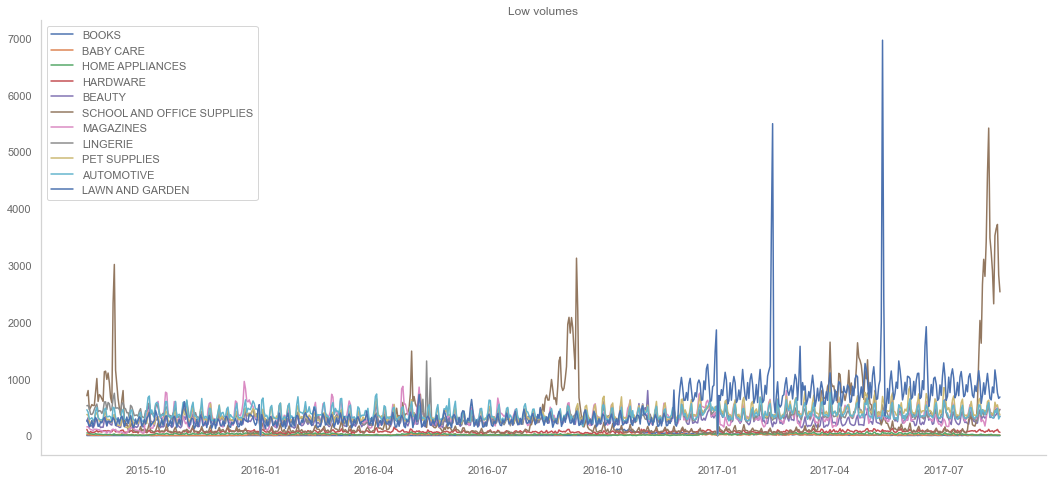

In [18]:
plt.figure(figsize=FIGSIZE)
plt.plot(total_sales_df[low_vol_columns])
plt.legend(low_vol_columns, loc='best')
plt.title('Low volumes')
plt.show()

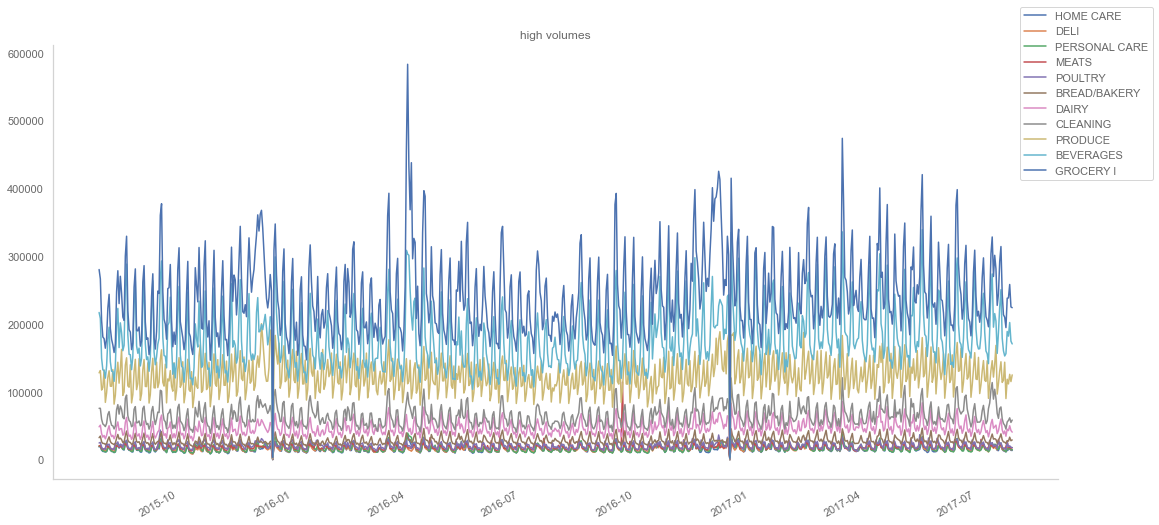

In [19]:
plt.figure(figsize=FIGSIZE)
plt.plot(total_sales_df[high_vol_columns])
plt.legend(high_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.title('high volumes')
plt.xticks(rotation=30)
plt.show()

# Forecasting

largest volume of data

In [20]:
feature = 'PRODUCE'
prediction_days = 30

In [21]:
df = total_sales_df[[feature]].reset_index()
df.head(10)

family,date,PRODUCE
0,2015-08-15,128147.18
1,2015-08-16,131493.93
2,2015-08-17,102769.60
3,2015-08-18,106468.23
4,2015-08-19,132449.58
5,2015-08-20,84588.25
6,2015-08-21,98670.76
7,2015-08-22,121189.08
8,2015-08-23,131169.49
9,2015-08-24,108400.87


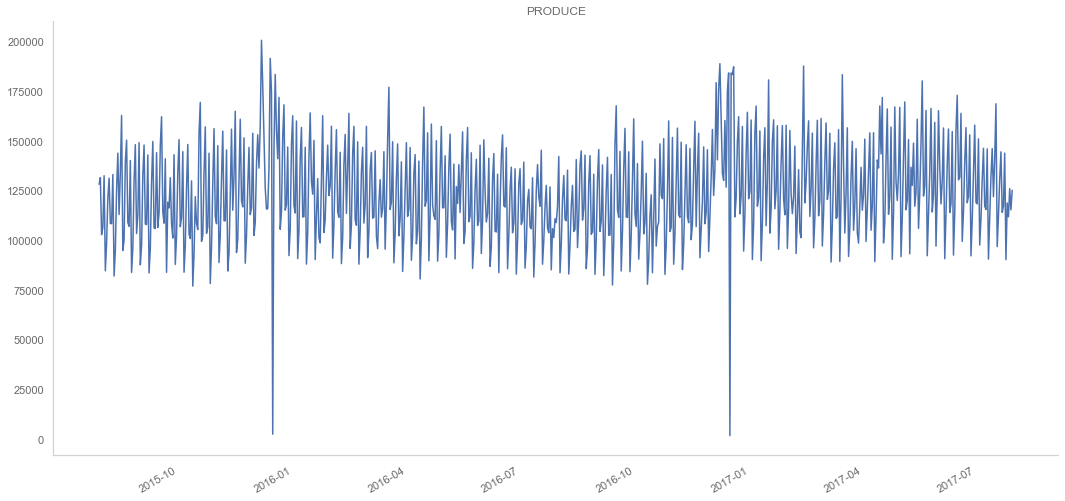

In [22]:
plt.figure(figsize=FIGSIZE)
plt.plot(df.date, df.PRODUCE)
plt.title(feature)
plt.xticks(rotation=30)
plt.show()

### Adding holiday data
*holyday link: [holidays](https://pypi.org/project/holidays/)*

In [23]:
#adding holiday data

holiday = pd.DataFrame([])

ecuador_holidays = holidays.EC()  # this is a dict
# the below is the same, but takes a string:
ecuador_holidays = holidays.country_holidays('EC')  # this is a dict


for date_, name in sorted(holidays.EC(years=[2015,2016,2017,2018]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "EC-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

,ds,holiday,lower_window,upper_window
0,2015-01-01,EC-Holidays,-2,1
1,2015-02-16,EC-Holidays,-2,1
2,2015-02-17,EC-Holidays,-2,1
3,2015-04-03,EC-Holidays,-2,1
4,2015-05-01,EC-Holidays,-2,1


#### Selecting the start date of the test dataset

In [24]:
forecast_start_dt = date(2017, 7, 1) # dataset ends of (2017, 8, 15)
forecast_start_date = (forecast_start_dt).strftime("%Y-%m-%d")
print(forecast_start_date)

2017-07-01


## Prophet Model

In [25]:
df_copy = df.copy()
df_copy = df_copy.rename(columns={ 'date': 'ds', feature: 'y' })
df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

df_copy['ds'] = pd.to_datetime(df_copy['ds'])

train_set = df_copy[(df_copy['ds'] < forecast_start_date)]

In [26]:
model = Prophet()
model.fit(train_set)

23:19:48 - cmdstanpy - INFO - Chain [1] start processing
23:19:49 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
future = model.make_future_dataframe(periods=prediction_days) # 30 days
fcst_prophet_train = model.predict(future)

In [28]:
# Adding a filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds'] >= forecast_start_date
predicted_df = fcst_prophet_train[filter][['ds', 'yhat']]

In [29]:
predicted_df.head(10)

,ds,yhat
684,2017-07-01,144618.47
685,2017-07-02,155341.69
686,2017-07-03,122390.83
687,2017-07-04,127649.41
688,2017-07-05,160258.38
689,2017-07-06,102675.74
690,2017-07-07,116024.44
691,2017-07-08,144872.51
692,2017-07-09,155595.73
693,2017-07-10,122644.87


In [30]:
df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)

In [31]:
predicted_df.head(5)

,ds,yhat,ytrue
0,2017-07-01,144618.47,155487.63
1,2017-07-02,155341.69,172890.14
2,2017-07-03,122390.83,130389.20
3,2017-07-04,127649.41,131534.55
4,2017-07-05,160258.38,163804.33


In [32]:
mape(predicted_df['ytrue'], predicted_df['yhat'])

6.2695463285966

### Cross Validation

In [33]:
from prophet.diagnostics import cross_validation

model = Prophet()
model.fit(train_set)

df_cv = cross_validation(model, initial='365 days', period='30 days', horizon='30 days')

23:19:49 - cmdstanpy - INFO - Chain [1] start processing
23:19:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/10 [00:00<?, ?it/s]

23:19:49 - cmdstanpy - INFO - Chain [1] start processing
23:19:49 - cmdstanpy - INFO - Chain [1] done processing
23:19:50 - cmdstanpy - INFO - Chain [1] start processing
23:19:50 - cmdstanpy - INFO - Chain [1] done processing
23:19:50 - cmdstanpy - INFO - Chain [1] start processing
23:19:50 - cmdstanpy - INFO - Chain [1] done processing
23:19:50 - cmdstanpy - INFO - Chain [1] start processing
23:19:50 - cmdstanpy - INFO - Chain [1] done processing
23:19:51 - cmdstanpy - INFO - Chain [1] start processing
23:19:51 - cmdstanpy - INFO - Chain [1] done processing
23:19:51 - cmdstanpy - INFO - Chain [1] start processing
23:19:51 - cmdstanpy - INFO - Chain [1] done processing
23:19:51 - cmdstanpy - INFO - Chain [1] start processing
23:19:51 - cmdstanpy - INFO - Chain [1] done processing
23:19:51 - cmdstanpy - INFO - Chain [1] start processing
23:19:52 - cmdstanpy - INFO - Chain [1] done processing
23:19:52 - cmdstanpy - INFO - Chain [1] start processing
23:19:52 - cmdstanpy - INFO - Chain [1]

In [34]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,413361172.92,20331.29,13110.68,0.09,0.07,0.10,0.80
1,4 days,270356083.07,16442.51,11138.40,0.08,0.06,0.08,0.80
2,5 days,141922529.27,11913.12,8919.14,0.07,0.06,0.07,0.87
3,6 days,126636792.69,11253.30,9242.82,0.07,0.07,0.07,0.87
4,7 days,96397132.07,9818.20,8434.36,0.07,0.07,0.07,0.93
5,8 days,76373330.37,8739.18,7696.80,0.06,0.06,0.06,0.97
6,9 days,61480678.71,7840.96,6605.30,0.06,0.04,0.05,1.00
7,10 days,49333979.83,7023.82,5436.31,0.05,0.04,0.05,1.00
8,11 days,78693034.51,8870.91,6725.70,0.05,0.04,0.05,0.97
9,12 days,83386129.88,9131.60,6726.87,0.05,0.05,0.05,0.93


#### More granular mapping

In [35]:
df_cv['mape'] = (df_cv['y'] - df_cv['yhat']) / (df_cv['y']) * 100

df_cv['overestimate'] = df_cv['yhat'] > df_cv['y'] 

df_cv.sort_values('mape',ascending=False).head(20)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
110,2016-12-23,98436.01,82555.64,113087.69,176327.97,2016-12-02,44.17,False
116,2016-12-30,98482.27,83307.29,114515.47,175022.19,2016-12-02,43.73,False
109,2016-12-22,87948.81,70828.29,103801.34,140444.94,2016-12-02,37.38,False
119,2017-01-02,116970.37,99053.79,137564.00,184113.03,2017-01-01,36.47,False
120,2017-01-03,121230.03,101677.65,140545.76,183306.23,2017-01-01,33.86,False
111,2016-12-24,127835.66,112189.66,143237.57,188809.16,2016-12-02,32.29,False
117,2016-12-31,127881.92,112694.96,144667.50,184154.67,2016-12-02,30.56,False
115,2016-12-29,87995.07,73032.24,104983.70,126652.84,2016-12-02,30.52,False
238,2017-05-01,126221.70,105475.28,146065.00,167558.58,2017-04-01,24.67,False
108,2016-12-21,143739.73,127967.33,158852.68,179251.71,2016-12-02,19.81,False


In [36]:
df_cv.sort_values('mape',ascending=False).tail(20)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
213,2017-04-06,104798.30,84845.98,124017.24,91817.68,2017-04-01,-14.14,True
171,2017-02-23,107485.69,87329.46,127371.27,93296.61,2017-01-31,-15.21,True
223,2017-04-16,157919.60,138908.56,178442.24,136626.82,2017-04-01,-15.58,True
162,2017-02-14,130391.01,112601.71,147948.65,112781.16,2017-01-31,-15.61,True
237,2017-04-30,159050.74,140530.37,178410.51,136304.71,2017-04-01,-16.69,True
204,2017-03-28,131028.23,111346.99,149505.45,111833.74,2017-03-02,-17.16,True
217,2017-04-10,124524.99,104747.52,143374.53,104994.85,2017-04-01,-18.60,True
234,2017-04-27,106495.00,86999.99,127541.30,89218.85,2017-04-01,-19.36,True
221,2017-04-14,117774.16,98998.58,138179.27,98551.68,2017-04-01,-19.50,True
199,2017-03-23,106387.69,87537.59,125335.12,89006.73,2017-03-02,-19.53,True


## Hyperparameters tuning

In [37]:
param_grid = {  
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 10.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = [] 

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_set)  # Fit model with given params
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

23:19:53 - cmdstanpy - INFO - Chain [1] start processing
23:19:53 - cmdstanpy - INFO - Chain [1] done processing
23:19:58 - cmdstanpy - INFO - Chain [1] start processing
23:19:58 - cmdstanpy - INFO - Chain [1] done processing
23:20:03 - cmdstanpy - INFO - Chain [1] start processing
23:20:03 - cmdstanpy - INFO - Chain [1] done processing
23:20:09 - cmdstanpy - INFO - Chain [1] start processing
23:20:09 - cmdstanpy - INFO - Chain [1] done processing
23:20:14 - cmdstanpy - INFO - Chain [1] start processing
23:20:14 - cmdstanpy - INFO - Chain [1] done processing
23:20:19 - cmdstanpy - INFO - Chain [1] start processing
23:20:19 - cmdstanpy - INFO - Chain [1] done processing
23:20:25 - cmdstanpy - INFO - Chain [1] start processing
23:20:25 - cmdstanpy - INFO - Chain [1] done processing
23:20:31 - cmdstanpy - INFO - Chain [1] start processing
23:20:31 - cmdstanpy - INFO - Chain [1] done processing
23:20:37 - cmdstanpy - INFO - Chain [1] start processing
23:20:37 - cmdstanpy - INFO - Chain [1]

In [38]:
print(tuning_results)

   changepoint_prior_scale  seasonality_prior_scale     rmse
0                     0.01                     0.10 17783.85
1                     0.01                     1.00 17762.83
2                     0.01                    10.00 17719.63
3                     0.10                     0.10 17747.48
4                     0.10                     1.00 17724.97
5                     0.10                    10.00 17725.03
6                     0.50                     0.10 17735.37
7                     0.50                     1.00 17757.46
8                     0.50                    10.00 17751.97


In [39]:
tuning_results.sort_values('rmse')

,changepoint_prior_scale,seasonality_prior_scale,rmse
2,0.01,10.00,17719.63
4,0.10,1.00,17724.97
5,0.10,10.00,17725.03
6,0.50,0.10,17735.37
3,0.10,0.10,17747.48
8,0.50,10.00,17751.97
7,0.50,1.00,17757.46
1,0.01,1.00,17762.83
0,0.01,0.10,17783.85


In [40]:
tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0]

changepoint_prior_scale       0.01
seasonality_prior_scale      10.00
rmse                      17719.63
Name: 0, dtype: float64

In [57]:
params_dict = dict(tuning_results.sort_values('rmse').reset_index(drop=True).drop('rmse', axis='columns').iloc[0])

model = Prophet(changepoint_prior_scale = params_dict['changepoint_prior_scale'], 
            seasonality_prior_scale = params_dict['seasonality_prior_scale'])

In [58]:
model.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days+30)
fcst_prophet_train = model.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds'] >= forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)
mape(predicted_df['ytrue'], predicted_df['yhat'])

23:30:40 - cmdstanpy - INFO - Chain [1] start processing
23:30:40 - cmdstanpy - INFO - Chain [1] done processing


6.033585154657113

Text(0.5, 1.0, 'Forecast Prothet')

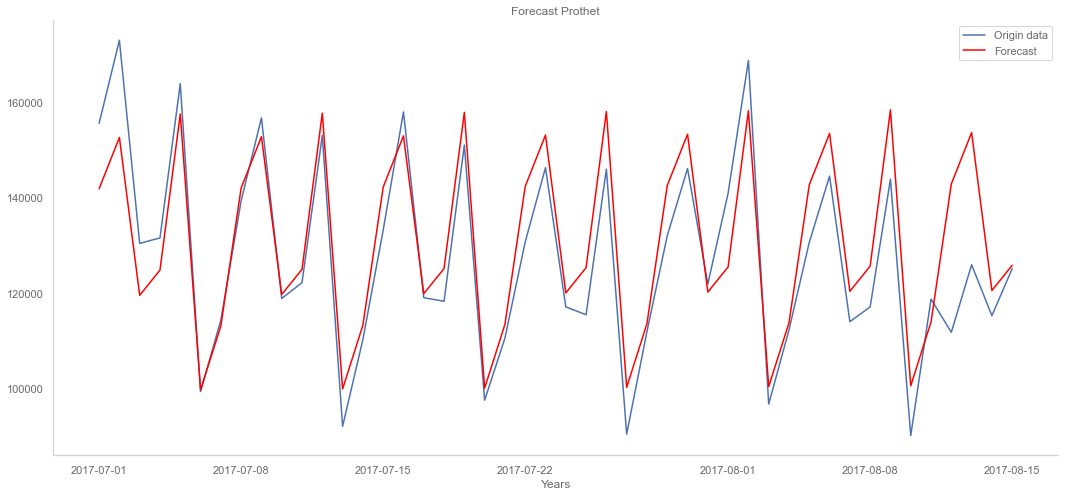

In [59]:
df_copy_filtered = df_copy[df_copy['ds'] >= "2017-07-01"]

plt.figure(figsize=FIGSIZE)
plt.plot(df_copy_filtered['ds'], df_copy_filtered['ytrue'])
plt.plot(predicted_df['ds'], predicted_df['yhat'], 'red')
plt.legend(["Origin data", "Forecast"])
plt.xlabel("Years")
plt.title("Forecast Prothet")